## Predictive Modeling NEW

# Lending Club Loan Default Predictions 1
**Author: Thomas Loeber**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Predictive-Modeling-NEW" data-toc-modified-id="Predictive-Modeling-NEW-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Predictive Modeling NEW</a></span></li><li><span><a href="#Load-data-and-saved-models" data-toc-modified-id="Load-data-and-saved-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data and saved models</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Predictive-Modelling" data-toc-modified-id="Predictive-Modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predictive Modelling</a></span><ul class="toc-item"><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Logistic-regression-+-Ridge" data-toc-modified-id="Logistic-regression-+-Ridge-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Logistic regression + Ridge</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>SVM</a></span></li></ul></li><li><span><a href="#OLD" data-toc-modified-id="OLD-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>OLD</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Ridge/Lasso-+-LogisticRegressionCV" data-toc-modified-id="Ridge/Lasso-+-LogisticRegressionCV-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Ridge/Lasso + LogisticRegressionCV</a></span></li><li><span><a href="#SGDClassifier-(elastic-net)-+-GridSearchCV" data-toc-modified-id="SGDClassifier-(elastic-net)-+-GridSearchCV-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>SGDClassifier (elastic net) + GridSearchCV</a></span><ul class="toc-item"><li><span><a href="#iid=True" data-toc-modified-id="iid=True-7.2.1"><span class="toc-item-num">7.2.1&nbsp;&nbsp;</span>iid=True</a></span></li><li><span><a href="#With-iid-=-False" data-toc-modified-id="With-iid-=-False-7.2.2"><span class="toc-item-num">7.2.2&nbsp;&nbsp;</span>With iid = False</a></span></li></ul></li></ul></li><li><span><a href="#Load-pickled-data" data-toc-modified-id="Load-pickled-data-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Load pickled data</a></span></li></ul></div>

In [23]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
import missingno  # for visualizing missing data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature

# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

## Load data and saved models

In [25]:
# Load original data
with open('data_processed/all_data.pickle', 'rb') as pickled_file: 
    all_data = pickle.load(pickled_file) 

## Preprocessing 

In [ ]:
# Find categorical variables with more than 50 unique values and drop them
unique_values_cat = all_data.select_dtypes(include='object') \
                        .nunique() \
                        .sort_values(ascending=False) 
print(unique_values_cat[unique_values_cat > 50])
# Drop variables
all_data = all_data.drop(unique_values_cat[unique_values_cat > 50].index,
    axis='columns')


# Train-test split (for now only select 1% for training)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(all_data.drop('default', axis='columns'),
                     all_data.default,
                     #train_size=0.8,
                     train_size=50000, test_size=50000,
                     random_state=1,
                     shuffle=True, stratify=all_data.default) 

# Imputation and standardization for numeric features
numeric_features = X_train.select_dtypes(include=[np.number]).columns
numeric_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]) 

# Imputation and one-hot encoding for categorical features
categorical_features = X_train.select_dtypes(include=[object]).columns
categorical_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combining preprocessing for both kinds of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough', n_jobs=1)

# Apply preprocessing
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

addr_state    51
dtype: int64


## PCA

In [ ]:
# Use PCA to assess whether features lie in lower-
# dimensional subspace
pca = PCA()
pca.fit(X_train_p)
explained_var = pca.explained_variance_ratio_

# Plot results
plt.figure(figsize=(12, 7))
plt.step(range(1, len(explained_var)+2),
         np.hstack([[0], np.cumsum(explained_var)]),
         color='black', label='Cumulative')
plt.bar(range(1, len(explained_var)+1),
        explained_var, 
        label='per principal component')
plt.legend('lowerright')
plt.title('Explained variance for different numbers of principal component')
plt.ylim(0,1.05)
plt.xlabel('Number of Component')
plt.ylabel('Explained Variance Ratio')
plt.show();

## Predictive Modelling
### Random Forests

In [ ]:
rf = RandomForestClassifier(n_estimators=100, 
        oob_score=True, n_jobs=3, random_state=1,
        class_weight='balanced_subsample')
rf.fit(X_train_p, y_train)


def plot_confusion_matrix(y_test, y_pred, digits=3):
    cf = pd.DataFrame(confusion_matrix(y_test, y_pred,
                                      labels=[1,0]),
                      columns=['True', 'False'])
    cf.index=['True', 'False']
    cf.columns.name = 'Predicted'
    cf.index.name = 'Actual'
    print(round(cf / len(y_test), digits))    

# Plot confusion matrix for random forests
y_pred_rf = rf.predict(X_test_p)
plot_confusion_matrix(y_test, y_pred_rf)


def plot_roc(y_test, y_pred, model_name=None):
    false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = {0:.3f}'.format(roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1],[0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title='ROC Curve'
    # Add custom title, if specified
    if model_name is not None:
        title = ', '.join([title, model_name])
    plt.title(title)
    plt.show();
    
# Plot ROC curve for random forests
y_pred_proba_rf = rf.predict_proba(X_test_p)[:, 1]
plot_roc(y_test, y_pred_proba_rf, 'Random Forests')

In [ ]:
def plot_precision_recall(y_test, y_pred):
    """Plots precision-recall curve."""

    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # pdb.set_trace()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.figtext(0.2, 0.2, 'Average Precision={0:0.3f}' \
                                    .format(average_precision))
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show();

# Plot precision recall curve for random forests classifier
plot_precision_recall(y_test, y_pred_proba_rf)

In [ ]:
# Get a list of feature names
cat_names = preprocessor.named_transformers_['cat'] \
                .named_steps['onehot'].get_feature_names()
feature_names = list(numeric_features) + list(cat_names)
# Compute feature importance and sort
feature_importances = pd.Series(
                            rf.feature_importances_,
                            index=feature_names) \
                        .sort_values(ascending=False)
print(feature_importances)

### Logistic regression + Ridge 

In [ ]:
lr_ridge = LogisticRegression(
    random_state=1, penalty='l2', class_weight='balanced', 
    C=1E-3, max_iter=100, n_jobs=3, solver='lbfgs')
lr_ridge.fit(X_train_p, y_train) 

# Plot confusion matrix
y_pred_lr = lr_ridge.predict(X_test_p)
plot_confusion_matrix(y_test, y_pred_lr)

# Plot ROC curve
y_pred_proba_lr = lr_ridge.predict_proba(X_test_p)[:, 1]
plot_roc(y_test, y_pred_proba_lr)

### SVM

In [ ]:
svm = SGDClassifier(loss='hinge', penalty='elasticnet', random_state=1,
                   class_weight='balanced', alpha=1E-2,
                    max_iter=100, tol=1E-3)
svm.fit(X_train_p, y_train)

# Plot confusion matrix
y_pred_svm = svm.predict(X_test_p)
plot_confusion_matrix(y_test, y_pred_svm)

# Plot ROC curve
y_pred_proba_svm = svm.decision_function(X_test_p)
plot_roc(y_test, y_pred_proba_svm)

In [ ]:
print(classification_report(y_test, y_pred_svm))

In [ ]:
variables_to_drop

## OLD

In [ ]:
# Save preprocessed data
for data in ['X_train_p', 'X_test_p', 'y_train', 'y_test']:
    with open('data_processed/{}.joblib'.format(data)
            as saved_file:
        joblib.dump(saved_file)

In [12]:
def plot_confusion_matrix(y_test, y_pred, digits=3):
    cf = pd.DataFrame(confusion_matrix(y_test, y_pred,
                                      labels=[1,0]),
                      columns=['True', 'False'])
    cf.index=['True', 'False']
    cf.columns.name = 'Predicted'
    cf.index.name = 'Actual'
    print(round(cf / len(y_test), digits))
    
# Plot confusion matrix for random forests
y_pred_rf = rf.predict(X_test_p)
plot_confusion_matrix(y_test, y_pred_rf)

Predicted   True  False
Actual                 
True       0.004  0.201
False      0.003  0.793


In [ ]:
def plot_precision_recall(y_test, y_pred):
    """Plots precision-recall curve."""

    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # pdb.set_trace()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.figtext(0.2, 0.2, 'Average Precision={0:0.3f}' \
                                    .format(average_precision))
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show();

# Plot precision recall curve for random forests classifier
plot_precision_recall(y_test, y_pred_rf)

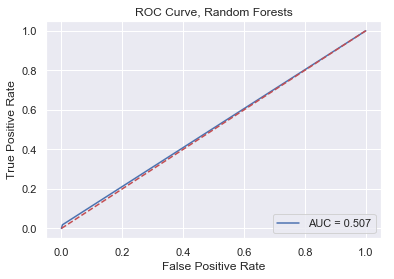

In [19]:
def plot_roc(y_test, y_pred, model_name=None):
    false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = {0:.3f}'.format(roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1],[0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title='ROC Curve'
    # Add custom title, if specified
    if model_name is not None:
        title = ', '.join([title, model_name])
    plt.title(title)
    plt.show();

# Plot ROC curve for random forests
plot_roc(y_test, y_pred_rf, 'Random Forests')

## Logistic regression
### Ridge/Lasso + LogisticRegressionCV

In [ ]:
# Ridge CV, stochastic gradient descent, additional iterations
lr_ridge_cv = LogisticRegressionCV(Cs = 4, solver='saga', cv=3,
    random_state=1, penalty='l2', class_weight='balanced', 
    max_iter=1000)
lr_ridge_cv.fit(X_train_p, y_train) 

In [ ]:
# Performance during cross-validation
lr_ridge_cv.scores_

In [ ]:
# Performance on test set
lr_ridge_cv.score(X_test_p, y_test)

Now we only get the convergence warning for part of the models.

Let's try the same now using LogisticRegression + GreatSearchCV, because this gives a better description of the results.

**Try default solver**

In [ ]:
# Try default solver (Ridge CV, additional iterations)
lr_ridge_cv_2 = LogisticRegressionCV(Cs = 4, cv=3,
    random_state=1, penalty='l2', class_weight='balanced',
    max_iter=1000)
lr_ridge_cv_2.fit(X_train_p, y_train) 

In [ ]:
# Performance during cross-validation
lr_ridge_cv_2.scores_

In [ ]:
# Performance on test set
lr_ridge_cv_2.score(X_test_p, y_test)

In [ ]:
# Plot confusion matrix
y_pred_lr = lr_ridge_cv_2.predict(X_test_p)
plot_confusion_matrix(y_test, y_pred_lr)

In [ ]:
# Plot precision-recall curve
plot_precision_recall(y_test, y_pred_lr)

In [ ]:
# Plot ROC curve
plot_roc(y_test, y_pred_lr)

Default solver gets rid of the convergence warnings completely.

Next, try Lasso.

In [ ]:
# joblib.dump(lr_ridge, 'lr_ridge.Joblib')

In [ ]:
# Lasso CV (Stochastic gradient descent, default number of iterations
lr_lasso_cv = LogisticRegressionCV(Cs = 4, solver='saga', cv=3,
    random_state=1, penalty='l1', class_weight='balanced')
lr_lasso_cv.fit(X_train_p, y_train) 

In [ ]:
lr_lasso_cv.scores_

In [ ]:
lr_lasso_cv.score(X_test_p, y_test)

### SGDClassifier (elastic net) + GridSearchCV

In [ ]:
# Elastic net, logistic regression (Loss='log')
lr_en = SGDClassifier(loss='log', penalty='elasticnet', random_state=1,
                   class_weight='balanced', n_jobs=1) 

# Parameters to search over
grid={'l1_ratio': np.linspace(0, 1, 4),
      'alpha': np.logspace(-10, 1, 11)}

#### iid=True 

In [ ]:
gs_el_t = GridSearchCV(lr_en, param_grid=grid, iid=True,
                       scoring='f1', cv=3, n_jobs=3)
gs_el_t.fit(X_train_p, y_train)

In [ ]:
gs_el_t.scorer_

In [ ]:
# Cross-validation accuracy
gs_el_t.score(X_test_p, y_test)

In [ ]:
# Plot confusion matrix
y_pred_el_t = gs_el_t.predict(X_test_p)
plot_confusion_matrix(y_test, y_pred_el_t)

In [ ]:
plot_precision_recall(y_test, y_pred_el_t)

In [ ]:
# Plot ROC curve
plot_roc(y_test, y_pred_el_t)

In [ ]:
# joblib.dump(gscv_t, 'gscv_t.joblib') # Save

#### With iid = False

In [ ]:
gs_el_f = GridSearchCV(lr_en, param_grid=grid, iid=False, cv=3, n_jobs=3)
gs_el_f.fit(X_train_p, y_train)

In [ ]:
gs_el_f.score(X_test_p, y_test)

In [ ]:
y_pred_el_t = gs_el_t.predict(X_test_p)
plot_precision_recall(y_test, y_pred_el_t)

In [ ]:
np.unique(y_pred_el_t, return_counts=True)

In [ ]:
# Plot ROC curve
plot_roc(y_test, y_pred_el_t)

In [ ]:
pd.DataFrame(gs_el_t.cv_results_) \
    .set_index('params') \
    .loc[:,['mean_test_score', 'mean_train_score',
           'split0_test_score', 'split1_test_score','split2_test_score',
           'split0_train_score', 'split1_train_score','split2_train_score']] 

In [ ]:
# joblib.dump(gscv_f, 'gscv_f.joblib') # Save

Let's look at the results. I'm displaying the accuracy for all folds here, because in previous iterations they sometimes widely differed. (In fact, the problems occurred when I was still trying to use all the data, so it is particularly surprising that with almost a million observations, there would be such severe overfitting).

Note: the higher alpha, the *stronger* the regularization.

In [ ]:
pd.DataFrame(gs_el_f.cv_results_) \
    .set_index('params') \
    .loc[:,['mean_test_score', 'mean_train_score',
            'split0_test_score', 'split1_test_score','split2_test_score',
            'split0_train_score', 'split1_train_score','split2_train_score']] 

In [ ]:
# Learning curve (Random forests)
ns = [100, 1000, 10000, 100000, 300000, 600000, 818660]
f1_scores = {}
for n in ns:
    X_train_p_subset, y_train_subset = resample(
        X_train_p, y_train, replace=False, n_samples=n, random_state=1)
    rf_subset = RandomForestClassifier(
        n_estimators=100, n_jobs=3, random_state=1,
        class_weight='balanced_subsample')
    rf_subset.fit(X_train_p_subset, y_train_subset)
    y_pred_rf_subset = rf_subset.predict(X_test_p)
    f1_scores[n] = f1_score(y_test, y_pred_rf_subset)

plt.plot(pd.Series(f1_scores))
plt.title('Learning Curve')
plt.xlabel('Number of Observations')
plt.ylabel('F1-score')

## Load pickled data

In [ ]:
# Raise error, because we only want to execute the next cells manually
raise Exception